# Bayesian Deep Learning 

In [1]:
import torch
from torch import nn
from torch.utils.cpp_extension import load
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Nice dark plotting settings
import seaborn as sns
sns.set_style('darkgrid',
                {'axes.facecolor': '.2',
                'figure.facecolor': '0.1',
                'text.color': '.9',
                'grid.color': '.5',
                'xtick.color': '.9',
                'ytick.color': '.9'})

In [3]:
# Load C++ extensions
bnets = load(name='bayesian_nets',
             sources=['bayesian_nets.cc'],
             extra_include_paths=['../../include'],
             extra_cflags=['-Wall -Wextra -Wpedantic -O3 -std=c++1z'],
             verbose=False)

In [4]:
N_tr = 6
N_val = 300

x_val = torch.linspace(-5,5,N_val).view(-1,1)
y_val = torch.sin(x_val).view(-1,1)

x_train = torch.linspace(-3.14,3.14,N_tr).view(-1,1)
y_train = torch.sin(x_train).view(-1,1) + torch.randn_like(x_train)*0.1

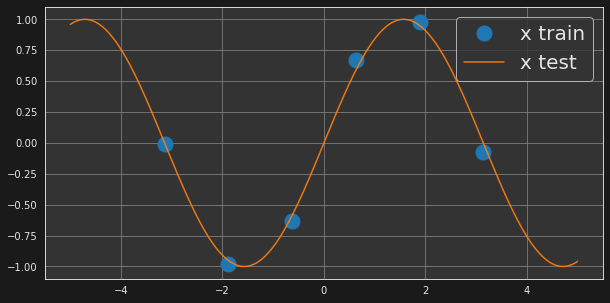

In [5]:
plt.figure(figsize=(10,5))
plt.plot(x_train.numpy(),y_train.numpy(),'.',markersize=30, label='x train')
plt.plot(x_val.numpy(),y_val.numpy(),'C1',alpha=0.9, markersize=2, label='x test')

plt.legend(fontsize=20)
plt.show()

In [6]:
class Net(torch.nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        self.l1 = nn.Linear(1, 10, bias = True)
        self.l2 = nn.Linear(10, 10, bias = True)
        self.l3 = nn.Linear(10, 1, bias = True)

    def forward(self, x):
        x = self.l1(x)
        x = torch.relu(x)
        x = self.l2(x)
        x = torch.relu(x)
        x = self.l3(x)
        return x

net = Net()
jit_net = torch.jit.script(net)
jit_net.save('jit_net.pt')

```cpp
torch::Tensor train_jit_module(
        std::string jit_model_pt,
        torch::Tensor x_val,
        torch::Tensor x_train,
        torch::Tensor y_train,
        int nepochs) {

    auto module = load_module(jit_model_pt);
    if (!module.has_value())
        return torch::Tensor{};

    auto net = module.value();
    auto params = parameters(net);

    auto loss_fn = torch::nn::MSELoss{};
    auto optimizer = torch::optim::Adam{params, torch::optim::AdamOptions(0.005)};

    auto inputs_val = std::vector<torch::jit::IValue>{x_val};
    auto inputs_train = std::vector<torch::jit::IValue>{x_train};

    auto preds = std::vector<at::Tensor>{};
    preds.reserve(nepochs);

    net.train();

    for (int i = 0; i < nepochs; i++) {

        optimizer.zero_grad();
        auto output = net.forward(inputs_train).toTensor();
        auto loss = loss_fn(output, y_train);
        loss.backward();
        optimizer.step();

        preds.push_back(net.forward(inputs_val).toTensor().detach());
    }

    return torch::stack(preds);
}
```

In [7]:
predictions = bnets.train_jit_module('jit_net.pt', x_val, x_train, y_train, 250)

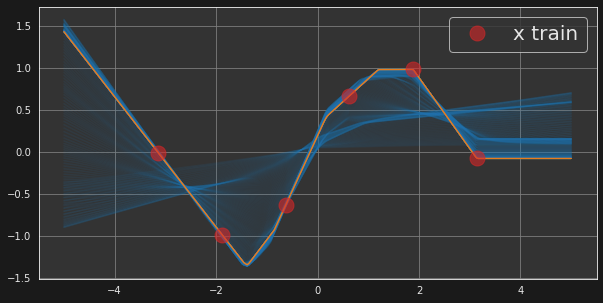

In [8]:
plt.figure(figsize=(10,5))
plt.plot(x_val.numpy(), predictions.numpy().squeeze().T, 'C0',alpha=0.1)
plt.plot(x_val.cpu().numpy(),predictions[-1].numpy().squeeze().T, 'C1',alpha=0.9)
plt.plot(x_train.numpy(), y_train.numpy(),'.C3',markersize=30, label='x train',alpha=0.6)
plt.legend(fontsize=20)
plt.show()